# Space debris and other man-made objects

In this notebook, we try to understand fast moving objects seen in single exposure. These objects usually leave discrete tracks (several connected dots), the magnitude is rather low, and their magnitude can oscillate (e.g. rotating objects). 

In order to study these objects, we reduce the initial data set to keep only relevant alerts. We keep alerts that satisfy the following criteria:
- the alert must pass the quality cuts
- the alert must not be cataloged in the Minor Planet Center database
- the alert must not be cataloged in the SIMBAD database
- the alert must not have been seen more than 2 times (1 point in the history)

In the period 2021/01/01 to 2021/03/18, we had 5,028,691 alerts that passed the quality cuts, and only 160,354 alerts that satisfy all criteria above (3%).

## Loading the data

The folder contains `parquet` file. You can just use pandas to load them:

In [1]:
import pandas as pd

# Change the path accordingly
pdf = pd.read_parquet('../part-00000-060ecff6-8768-4213-9358-3ecb6f213824-c000.snappy.parquet')

In [2]:
pdf

,ra,dec,candid,chipsf,classtar,diffmaglim,distnr,distpsnr1,drb,fid,...,sigmagnr,magzpsci,isdiffpos,nbad,nid,objectId,rb,xpos,ypos,cdsxmatch
0,132.000077,-18.483776,1466373491915010048,4.354350,0.992,18.271688,0.195191,0.161605,0.992402,1,...,0.011,24.906652,f,0,1466,ZTF21aabmbje,0.828571,2881.418213,1859.604614,Unknown
1,138.923682,-19.983133,1466373950215015002,1.461408,0.764,18.568514,0.593374,0.617464,0.868611,1,...,0.015,25.250601,t,0,1466,ZTF20acwdfhr,0.810000,245.100204,380.093811,Unknown
2,138.108223,-20.637652,1466373950215010040,1.059133,0.808,18.568514,0.350426,0.333622,0.265154,1,...,0.010,25.250601,f,0,1466,ZTF19aacicnf,0.681429,2995.491943,2670.930664,Unknown
3,127.628566,-13.419542,1466371600215010041,0.977769,0.956,18.648737,0.515773,0.506281,0.999194,1,...,0.011,25.158184,f,0,1466,ZTF21aabmbkg,0.818571,1226.775146,2601.092773,Unknown
4,136.653117,-26.589303,1466374430115015023,2.798596,0.983,18.692993,1.037978,1.249794,0.752905,1,...,0.011,25.425184,t,0,1466,ZTF21aabmbkn,0.612857,1461.386963,1363.254395,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160349,99.577830,-12.355684,1520244020115015022,1.118919,0.568,18.701174,0.800529,0.858756,0.250074,1,...,0.011,26.226252,t,0,1520,ZTF21aanqtzp,0.577143,328.727692,1871.777588,Unknown
160350,212.896644,-12.618856,1471461730015015091,16.279947,0.996,18.265028,0.672639,0.705869,0.694263,1,...,0.009,24.982800,t,0,1471,ZTF20aaytbky,0.561429,2720.988525,2766.466064,Unknown
160351,131.389195,25.443188,1471378981715015020,1.509894,0.990,20.417995,2.567175,16.619986,0.999295,2,...,0.133,26.271854,t,0,1471,ZTF21aadjlus,0.731429,1244.606323,2175.361572,Unknown
160352,118.396961,3.982505,1471367632015015009,0.803778,0.970,20.459841,9.752568,11.563689,0.999993,2,...,0.179,26.271309,t,0,1471,ZTF21aadjbhe,0.701429,1484.241699,1750.164307,Unknown


Let's plot data for one particular day (2021/03/18):

number of alerts:  2427


Text(0.5, 1.0, 'ZTF alerts on 2021-03-18')

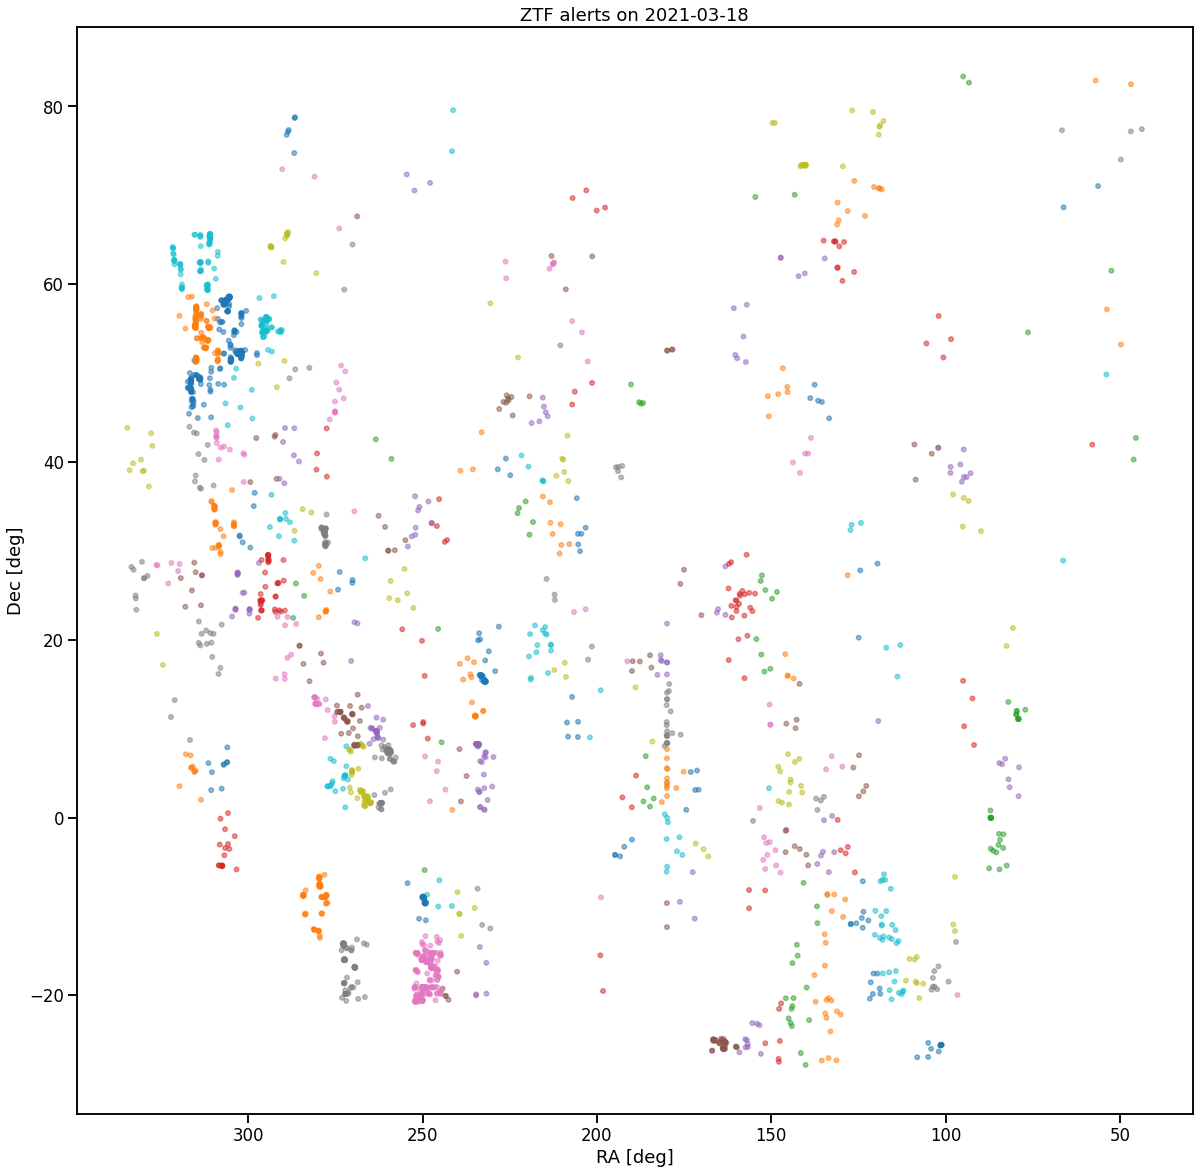

In [12]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from astropy.time import Time

seaborn.set_context('talk')

date_iso = '2021-03-18'
date = int(Time(date_iso, format='iso').jd)
mask = pdf['jd'].apply(lambda x: int(x) == date)
print('number of alerts: ', np.sum(mask))

# Color code by ZTF field -- needs matplotlib > 3.0.1
colors = {i: 'C{}'.format(j) for j, i in enumerate(np.unique(pdf[mask]['field']))}

_ = plt.figure(figsize=(20, 20))

plt.scatter(
    pdf[mask]['ra'], 
    pdf[mask]['dec'], 
    alpha=0.5, 
    marker='.', 
    color=pdf[mask]['field'].apply(lambda x: colors[int(x)])
)

plt.gca().invert_xaxis()
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

plt.title('ZTF alerts on {}'.format(date_iso))

## Challenge

The criteria above are probably not yet optimised, but they already reduce enough the number of candidates to start searching for real space debris (or any man-made objects). So the main challenge now is to design an algorithm to extract discrete tracks (aligned alerts) and look at their lightcurve.